## [論文](https://www.alphaxiv.org/pdf/1912.11245)

## 出発点の理論式
$$
\epsilon(\omega) = \epsilon_{\infty} - \frac{\omega_p^2}{\omega^2 + i\Gamma_{n}\omega}
$$

## 理論式の説明
出発点の理論式は、バルク金属の自由電子応答を記述する基本的なDrudeモデルにおいて、減衰項Γの修正を行ったものです

## 定数の説明
ε_∞: 高周波における背景誘電率（内殻電子の寄与） (9.0で固定)
Γ_n: ナノ粒子の減衰係数（バルクと表面散乱の寄与を含む） (1.0e15 s⁻¹で固定)
\omega: 入射光の周波数 (3.625e15で固定)

## 説明変数の説明
ω_p: プラズマ周波数（自由電子の集団振動の固有周波数）

## 着眼点
減衰係数 Γ の変更はピークの幅を調整しますが、位置は変えません。ピーク位置（共鳴周波数）のシフトを説明できるために、標準的なdrudeモデルの数式に新たな修正を行う必要があります。ナノ粒子サイズに依存するこのシフトをモデル化するような修正を考えてください。
**NEVER USE `if`. JUST EXPLORE FORMULA!!!**
**Previous formula does not fit the experimental data. Please propose a new modification**

## プログラムが発見した式
```python
def equation_v1(omega_p: np.ndarray, params: np.ndarray) -> np.ndarray:
    """ 
    Calculates the dielectric function of a material based on frequency, plasma frequency, and damping factor.

        Args:
            omega_p: Plasma frequency (rad/s).
            params: An array of optimizable parameters.

        Returns:
            The calculated dielectric function (complex number).

        Notes:
            epsilon_inf: High-frequency background dielectric constant (fixed at 9.0).
            gamma_n: Nanoparticle damping constant (fixed at 1.0e15 s⁻¹).
            omega: Incident light frequency (fixed at 3.625e15 rad/s).
    """
    epsilon_inf = 9.0
    gamma_n = 1.0e15
    omega = 3.625e15
    delta_omega_p = params[0]
    return epsilon_inf - (omega_p**2) / (omega**2 + 1j * gamma_n * omega + delta_omega_p*omega_p**2)
```

## 関数比較プロット
![img](./drude_plot.png)

## 想定解

$$
\epsilon = \epsilon_{\infty} - \frac{{\omega_p^2}}{{\omega^2 - \alpha \omega_p^2 + i \gamma_n \omega}}
$$

## 結果
数学的に等価な式がすぐに見つかった

固定された光の角周波数: 3.625e+15 rad/s
計算結果をCSVファイルに出力しました: /workspaces/mictlan/research/funsearch/examples/v1/dielectric_constant_vs_omega_p.csv


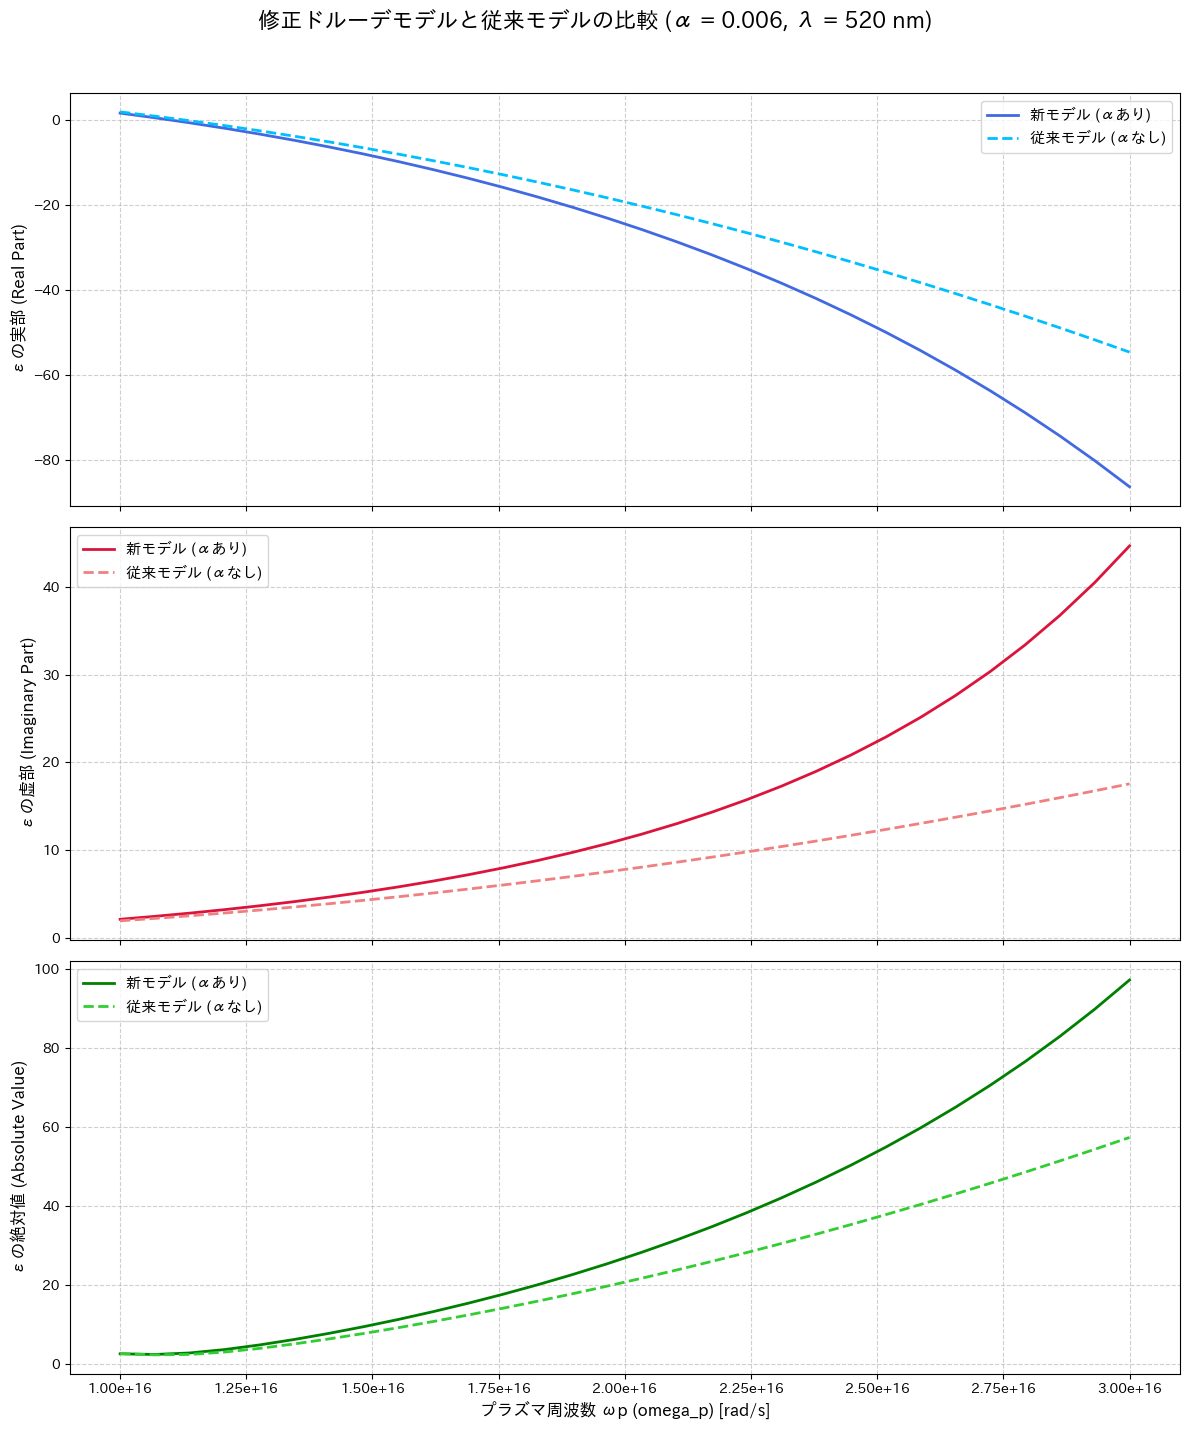

In [1]:
import numpy as np
import japanize_matplotlib
import matplotlib.pyplot as plt
import csv
import os

# --- 物理定数 ---
c = 3.0e8  # 光速 (m/s)

# --- 固定パラメータ (論文の文脈に基づき設定) ---
epsilon_inf = 9.0      # 高周波における背景誘電率
Gamma_n = 1.0e15       # ナノ粒子の減衰係数 (s⁻¹)
alpha_fixed = 0.006    # 復元力係数αを固定 (論文の図2を参考に設定)

# 光の波長を520nmに固定（金のナノ粒子のプラモン共鳴が起こる代表的な波長）
wavelength_fixed_nm = 520.0
wavelength_fixed_m = wavelength_fixed_nm * 1e-9
omega_fixed = 2 * np.pi * c / wavelength_fixed_m
print(f"固定された光の角周波数: {omega_fixed:.3e} rad/s")
omega_fixed = 3.625e15  # NOTE: 諸事情により固定します、ここは変更しないでください。


# --- モデルの定義 ---
def first_stage_model(omega, omega_p):
    """
    第一段階のモデル（従来のドルーデモデル、α=0に相当）
    ε(ω) = ε_∞ - ω_p^2 / (ω^2 + iΓ_nω)
    """
    denominator = omega**2 + 1j * Gamma_n * omega
    epsilon = epsilon_inf - (omega_p**2) / denominator
    return epsilon


def second_stage_model(omega, omega_p, alpha):
    """
    第二段階の改良モデル（復元力の項αを追加）
    """
    denominator = omega**2 - alpha * omega_p**2 + 1j * Gamma_n * omega
    epsilon = epsilon_inf - (omega_p**2) / denominator
    return epsilon


# --- 計算の実行 ---
# 金のプラズマ周波数 1.37e16 (rad/s) を中心に範囲を設定
omega_p_range = np.linspace(1.0e16, 3.0e16, 30)

# 各モデルで誘電率を計算
epsilon_results_first = first_stage_model(omega_fixed, omega_p_range)
epsilon_results_second = second_stage_model(
    omega_fixed, omega_p_range, alpha_fixed)


# --- CSVファイルへの出力 (変更なし) ---
csv_filename = 'dielectric_constant_vs_omega_p.csv'
header = ['omega_p', 'epsilon_results_second_model']
data_rows = zip(omega_p_range, epsilon_results_second)

try:
    with open(csv_filename, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(header)
        writer.writerows(data_rows)
    print(f"計算結果をCSVファイルに出力しました: {os.path.abspath(csv_filename)}")
except IOError as e:
    print(f"ファイル出力中にエラーが発生しました: {e}")


# --- グラフのプロット ---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
fig.suptitle(
    f'修正ドルーデモデルと従来モデルの比較 (α = {alpha_fixed}, λ = {wavelength_fixed_nm:.0f} nm)', fontsize=16)

# --- 実部の比較 ---
ax1.plot(omega_p_range, epsilon_results_second.real,
         label="新モデル (αあり)", color='royalblue', linewidth=2)
ax1.plot(omega_p_range, epsilon_results_first.real,
         label="従来モデル (αなし)", color='deepskyblue', linestyle='--', linewidth=2)
ax1.set_ylabel("εの実部 (Real Part)", fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.tick_params(axis='y', which='major', labelsize=10)


# --- 虚部の比較 ---
ax2.plot(omega_p_range, epsilon_results_second.imag,
         label="新モデル (αあり)", color='crimson', linewidth=2)
ax2.plot(omega_p_range, epsilon_results_first.imag,
         label="従来モデル (αなし)", color='lightcoral', linestyle='--', linewidth=2)
ax2.set_ylabel("εの虚部 (Imaginary Part)", fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.tick_params(axis='y', which='major', labelsize=10)


# --- 絶対値の比較 ---
ax3.plot(omega_p_range, np.abs(epsilon_results_second),
         label="新モデル (αあり)", color='green', linewidth=2)
ax3.plot(omega_p_range, np.abs(epsilon_results_first),
         label="従来モデル (αなし)", color='limegreen', linestyle='--', linewidth=2)
ax3.set_xlabel("プラズマ周波数 ωp (omega_p) [rad/s]", fontsize=12)
ax3.set_ylabel("εの絶対値 (Absolute Value)", fontsize=12)
ax3.legend(fontsize=11)
ax3.grid(True, linestyle='--', alpha=0.6)
ax3.tick_params(axis='both', which='major', labelsize=10)
# x軸の表記を科学的表記法（指数表記）にする
ax3.xaxis.set_major_formatter(plt.FormatStrFormatter('%.2e'))

plt.tight_layout(rect=[0, 0.03, 1, 0.96])  # suptitleとの重なりを調整
plt.show()